In [1]:
import praw
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import datetime as dt
import torch
from tqdm.notebook import tqdm

client_id = 'QXgnNilxAJoowxnJqYSUmA'
client_secret = 'oigCTLqOddP8NkRg_CHbFDI0SElr3w'

reddit = praw.Reddit(client_id = client_id,
                     client_secret = client_secret,
                     user_agent = 'IS 596')

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis")
sentiment_toxicity = pipeline("sentiment-analysis", model="unitary/toxic-bert")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
C:\Users\ray\anaconda3\envs\Pytorch\lib\site-packages\torch\nn\modules\module.py:1402: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In [4]:
from pmaw import PushshiftAPI
api = PushshiftAPI()

In [5]:
subreddit_list = ["politics", "worldnews", "conservative","conspiracy"]

In [6]:
def subreddit_crawler(sub, limit = 10):
    subreddit = reddit.subreddit(sub)
    post_list = []
    submission_fields = ['id', 'author', 'title', 'selftext', 'num_comments',
              'score', 'upvote_ratio', 'url']
    
    for submission in subreddit.top(limit = limit, time_filter = "year"):
        to_dict = vars(submission)
        sub_dict = {field:to_dict[field] for field in submission_fields}
        post_list.append(sub_dict)
    
    subs_data = pd.DataFrame(data = post_list, columns=submission_fields)
    file_name = "data/" + "submission_" + sub + ".csv"
    subs_data.to_csv(file_name, index = False)

In [54]:
def data_processing(sub, field = "submission"):
    file_name = "data/" + field + "_" + sub + ".csv"
    df = pd.read_csv(file_name,index_col=0)
    print("subreddit : " + sub)
    print(df.describe())
    print(df.info())
    return df

In [43]:
def comment_parser(sub, checkpoint = 0):
    file_name = "data/" + "submission_" + sub + ".csv"
    df = pd.read_csv(file_name)
    
    sublist = df["id"].tolist()
    sublist = sublist[checkpoint:]
    fields = ['id', 'author', 'body',  'parent_id',
              'score', 'subreddit', 'subreddit_id' ]
    
    file_name = "data/" + "comment_" + sub + ".csv"
    
    if not checkpoint:
        df = pd.DataFrame(columns=fields)
        df.to_csv(file_name)
    
    for post in tqdm(sublist):
        comment_list = []
        submission = reddit.submission(post)
        submission.comments.replace_more(limit=8)
        for comment in submission.comments.list():
            to_dict = vars(comment)
            sub_dict = {field:to_dict[field] for field in fields}
            comment_list.append(sub_dict)
        df = pd.DataFrame(data = comment_list)
        df.to_csv(file_name, mode='a', header = False)
            
#     comm_data = pd.DataFrame(data = comment_list, columns=fields)
#     file_name = "data/" + sub + "_comment.csv"
#     subs_data.to_csv(file_name, index = False)

In [ ]:
for sub in subreddit_list:
    subreddit_crawler(sub, limit = 10)

KeyboardInterrupt: 

In [42]:
for sub in tqdm(subreddit_list):
    comment_parser(sub, checkpoint = 0)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyError: 'submission.id'

In [55]:
pol_submission = data_processing("politics", field = "submission")

subreddit : politics
       num_comments          score  upvote_ratio
count   1000.000000    1000.000000    1000.00000
mean    3351.287000   47589.902000       0.87574
std     2525.661836   15315.985498       0.05474
min      511.000000   28821.000000       0.65000
25%     1926.000000   36101.750000       0.85000
50%     2805.000000   43838.500000       0.89000
75%     4165.000000   55091.000000       0.91000
max    39789.000000  119394.000000       0.97000
<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, t2suj2 to xim3x2
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   author        960 non-null    object 
 1   title         1000 non-null   object 
 2   selftext      9 non-null      object 
 3   num_comments  1000 non-null   int64  
 4   score         1000 non-null   int64  
 5   upvote_ratio  1000 non-null   float64
 6   url           1000 non-null   object 
dtypes: float64(1), int64(2), object(4)
mem

In [56]:
pol_submission.reset_index(inplace = True)

In [16]:
for sub in subreddit_list:
    pol_comment_df = data_processing(sub, field = "comment")

subreddit : politics
               score
count  458957.000000
mean       62.673993
std       488.046742
min      -292.000000
25%         2.000000
50%         3.000000
75%        12.000000
max     34367.000000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 458957 entries, 0 to 1171
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            458957 non-null  object
 1   author        434679 non-null  object
 2   body          458953 non-null  object
 3   parent_id     458957 non-null  object
 4   score         458957 non-null  int64 
 5   subreddit     458957 non-null  object
 6   subreddit_id  458957 non-null  object
dtypes: int64(1), object(6)
memory usage: 28.0+ MB
None


FileNotFoundError: [Errno 2] No such file or directory: 'data/comment_worldnews.csv'

In [58]:
pol_submission_authors = dict(zip(pol_submission.id, pol_submission.author))

In [64]:
pol_submission_authors

{'t2suj2': 'phillygirllovesbagel',
 't11uq0': 'morenewsat11',
 'rxqvwi': nan,
 'vl6xm2': 'Arpith2019',
 'su3zob': 'Sweep145',
 'vjuvlk': 'gzingher',
 'tp4xtx': 'reddicyoulous',
 's739ob': nan,
 'xfaqpa': 'reftheloop',
 'ubo2ao': 'BilBrowning',
 'qfe73p': 'Fr1sk3r',
 'x8y56x': 'YouGov_Official',
 'spdw28': 'HabitualGibberish',
 't2blwr': 'Wookers1984',
 'wg50x2': 'Abs0lut_Unit',
 'tewol7': 'greenblue98',
 'wa8rrx': 'BousWakebo',
 'uq4prt': 'stoutshrimp',
 'vm0217': 'Arpith2019',
 'wm6x6k': 'PoliticiansAlwaysLie',
 'v9vhrp': 'newnemo',
 'vg2s02': 'wewewawa',
 's7qcz1': 'Catdog24z',
 'xxdxbk': 'PoliticsModeratorBot',
 's02nrx': nan,
 'vklb2z': 'benfelix1',
 'wwxuvy': 'DaFunkJunkie',
 'qqt9x7': 'damselfliesreddit',
 't3u5i4': 'Nick__________',
 'wbaqyz': 'Gambit08',
 'ux4foh': '11-110011',
 'xjgwl3': 'PandaMuffin1',
 'ut7h3d': 'bythesea_man',
 'x38tor': 'burning_dawn',
 'qhkr8f': 'shelltops',
 'vn00q0': 'StuffyGoose',
 'rz7wkf': 'BumblesAZ',
 'wq44xi': 'Thai-Reidj',
 'uhgdek': 'burning_daw

In [75]:
pol_submission_authors['i29c0t3']

KeyError: 'i29c0t3'

In [61]:
pol_top_level_comment_df = pol_comment_df[pol_comment_df['parent_id'].str.contains("t3")]

In [63]:
pol_top_level_comment_df

,id,author,body,parent_id,score,subreddit,subreddit_id
0,hynym3j,AutoModerator,"\nAs a reminder, this subreddit [is for civil ...",t3_t2suj2,1,politics,t5_2cneq
1,hyotmts,Lunar_Deer,Americans who support Putin can get fucked.,t3_t2suj2,7047,politics,t5_2cneq
2,hyo3bc6,workerbee77,Bob Mueller laid out the charges that Donald T...,t3_t2suj2,3706,politics,t5_2cneq
3,hyo265c,bobface222,He is almost correct,t3_t2suj2,15575,politics,t5_2cneq
4,hyoiog1,Jacob_C,I don't think people here understand the word ...,t3_t2suj2,1585,politics,t5_2cneq
...,...,...,...,...,...,...,...
547,iqxjao2,NJ-B,It was designed to go away when no longer need...,t3_xuhx8a,-14,politics,t5_2cneq
548,iqxypiw,State_Farm_Jake,Democrats LOVE more voting laws enacted. Anyth...,t3_xuhx8a,-15,politics,t5_2cneq
549,iqw88qd,Snoo-58014,Thank God!,t3_xuhx8a,-29,politics,t5_2cneq
550,iqvp5qe,joephusweberr,The Bernie Sanders memorial court strikes again.,t3_xuhx8a,-33,politics,t5_2cneq


In [85]:
pol_top_level_comment_df.dropna(inplace = True)

C:\Users\ray\AppData\Local\Temp/ipykernel_28708/3396524216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pol_top_level_comment_df.dropna(inplace = True)


In [87]:
relation = []
for index, row in pol_top_level_comment_df.iterrows():
    try:
        parent_author = pol_submission_authors[row["parent_id"][3:]]
        relation.append((row["author"], parent_author))
    except:
        pass

In [88]:
G_01 = nx.DiGraph()
G_01.add_nodes_from(pol_submission.author)
G_01.add_edges_from(relation)

In [89]:
def have_bidirectional_relationship(G, node1, node2):
    return G.has_edge(node1, node2) and G.has_edge(node2, node1)

In [92]:
biconnections = set()
for u, v in G_01.edges():
    if have_bidirectional_relationship(G_01, u, v):
        if u != v:
            biconnections.add((u, v))

In [93]:
biconnections

{('KinkyBADom', 'coffeespeaking'), ('coffeespeaking', 'KinkyBADom')}

KeyboardInterrupt: 

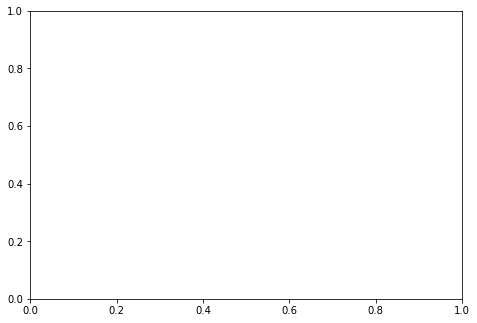

In [79]:
nx.draw(G_01)

In [31]:
pol_id_list = pol_comment_df["author"].tolist()

In [32]:
pol_id_list = [*set(pol_id_list)]